In [5]:
# Imports
import os
import sys
import torch
import numpy as np
from torch import nn
from PIL import Image
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms, models

In [24]:
DOWNLOAD = False # Switch To True If You Want To Parse Google

In [26]:
if DOWNLOAD:
  # Download Google Chrome Driver And Install Google Image Downloader 
  %pip uninstall google_images_download;pip install git+https://github.com/Joeclinton1/google-images-download.git
  !apt-get update # to update ubuntu to correctly run apt install
  !apt install chromium-chromedriver
  !cp /usr/lib/chromium-browser/chromedriver /usr/bin
  sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

  from google_images_download import google_images_download as gid

  # let's keep it simple and only learn this three colors
  COLORS = ('red', 'green', 'blue',)

  arguments = dict(limit=150, format='jpg', exact_size='200,200', chromedriver='/usr/bin/chromedriver')

  response = gid.googleimagesdownload()

  for color in COLORS:
    arguments = {**arguments, 'keywords': color, 'color': color, 'image_directory': color}
    response.download(arguments)
  # Download Data
  !zip -r downloads.zip downloads
  from google.colab import files
  files.download('downloads.zip')

In [12]:
# Check GPU - ON 
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
device

device(type='cuda')

In [13]:
# Spit Data To Train, Test Data And Retrieve Random Sample

from torch.utils.data.sampler import SubsetRandomSampler
VALIDATION_SIZE = 0.2
IMG_SIZE = 224

# transformation for images
transform = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


train_data = datasets.ImageFolder('downloads', transform=transform)
test_data = datasets.ImageFolder('downloads', transform=transform)

# split by random shuffling 
data_len = len(train_data)

indicies = list(range(data_len))
np.random.shuffle(indicies)

split_at = int(np.floor(VALIDATION_SIZE * data_len))
test_ids, train_ids = indicies[: split_at], indicies[split_at:]

train_loader = torch.utils.data.DataLoader(train_data, sampler=SubsetRandomSampler(train_ids), batch_size=64)
test_loader = torch.utils.data.DataLoader(test_data, sampler=SubsetRandomSampler(test_ids), batch_size=64)

classes = train_loader.dataset.classes
classes

['blue', 'green', 'red']

In [17]:
class ConvNet(nn.Module):
  def __init__(self, *args, **kwargs):
    super(ConvNet, self).__init__(*args, **kwargs)

    self.layer1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
    
    self.layer2 = nn.Sequential(
        nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
    
    self.layer3 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
    
    self.drop_out = nn.Dropout(p=0.2)
  
    self.fc1 = nn.Linear(32*int(IMG_SIZE/8)**2, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 256)
    self.fc4 = nn.Linear(256, 3)

  def forward(self, x):
    # Convolution
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)

    # Flatten & Register Drop Out
    out = out.reshape(out.size(0), -1)
    out = self.drop_out(out)

    # Fully Connected Layer
    out = self.fc1(out)
    out = self.fc2(out)
    out = self.fc3(out)
    out = self.fc4(out)

    return out


model = ConvNet()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.003)
criterion = nn.NLLLoss()

In [30]:
# Freeze The Pre-Trained Layers And Add Fully Connected Layer To Train Images -- OVERFITS -- DUH :D 

model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(
    # nn.Conv2d(512, 256, )
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 3),
    nn.LogSoftmax(dim=1)
)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [31]:
# Train & Display

epochs = 50
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in train_loader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += \
                   torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(test_loader))

            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(test_loader):.3f}.. "
                  f"Test accuracy: {accuracy/len(test_loader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'colour.pth')

Epoch 2/50.. Train loss: 0.816.. Test loss: 0.759.. Test accuracy: 0.697
Epoch 3/50.. Train loss: 0.488.. Test loss: 0.469.. Test accuracy: 0.852
Epoch 5/50.. Train loss: 0.245.. Test loss: 0.313.. Test accuracy: 0.899
Epoch 6/50.. Train loss: 0.181.. Test loss: 0.226.. Test accuracy: 0.918
Epoch 8/50.. Train loss: 0.128.. Test loss: 0.248.. Test accuracy: 0.907
Epoch 9/50.. Train loss: 0.107.. Test loss: 0.259.. Test accuracy: 0.903
Epoch 10/50.. Train loss: 0.075.. Test loss: 0.276.. Test accuracy: 0.887
Epoch 12/50.. Train loss: 0.084.. Test loss: 0.257.. Test accuracy: 0.914
Epoch 13/50.. Train loss: 0.058.. Test loss: 0.240.. Test accuracy: 0.891
Epoch 15/50.. Train loss: 0.046.. Test loss: 0.291.. Test accuracy: 0.887
Epoch 16/50.. Train loss: 0.047.. Test loss: 0.344.. Test accuracy: 0.891
Epoch 18/50.. Train loss: 0.066.. Test loss: 0.395.. Test accuracy: 0.907
Epoch 19/50.. Train loss: 0.029.. Test loss: 0.265.. Test accuracy: 0.899
Epoch 20/50.. Train loss: 0.029.. Test loss:

In [32]:
# Test Generalization
model = torch.load('colour.pth')
model.eval()

def predict_image(image):
  image_tensor = transform(image).float()
  image_tensor = image_tensor.unsqueeze_(0)
  input = Variable(image_tensor)
  input = input.to(device)
  output = model(input)
  index = output.data.cpu().numpy().argmax()
  return index

0 blue


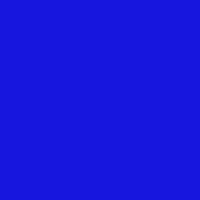

2 red


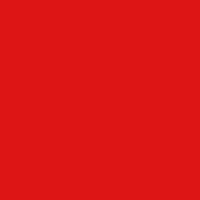

1 green


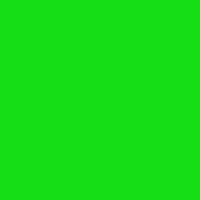

In [40]:
# COLOUR = 'blue'

# colors = [Image.open(f'DATA/{COLOUR}/'+image) for image in os.listdir(f'DATA/{COLOUR}')]
# for color in colors:
#   prediction = classes[predict_image(color)]
#   print(prediction, prediction == COLOUR)
from IPython import display


syntetic = [ (22, 22, 222), (222, 22, 22), (22, 222, 22)]
for clr in syntetic:
  im = Image.new('RGB', (200, 200), clr)
  prediction = predict_image(im)
  print(prediction, classes[prediction])
  display.display(im)

In [41]:
test_loss = 0
accuracy = 0
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        logps = model.forward(inputs)
        batch_loss = criterion(logps, labels)
        test_loss += batch_loss.item()
        
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += \
        torch.mean(equals.type(torch.FloatTensor)).item()
train_losses.append(running_loss/len(train_loader))
test_losses.append(test_loss/len(test_loader))

print(f"Epoch {epoch+1}/{epochs}.. "
      f"Train loss: {running_loss/print_every:.3f}.. "
      f"Test loss: {test_loss/len(test_loader):.3f}.. "
      f"Test accuracy: {accuracy/len(test_loader):.3f}")

Epoch 50/50.. Train loss: 0.000.. Test loss: 0.506.. Test accuracy: 0.848
